In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import keras
from keras_unet.models import custom_unet
from sklearn.model_selection import train_test_split

2023-05-01 03:02:26.391217: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
import cactas as C

In [4]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [5]:
images = np.load(images_file)
labels = np.load(labels_file)

In [6]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [7]:
images = images.astype(np.float64)
labels = labels.astype(np.float64)

In [8]:
p = np.random.permutation(len(images))
images = images[p]
labels = labels[p]

In [9]:
for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

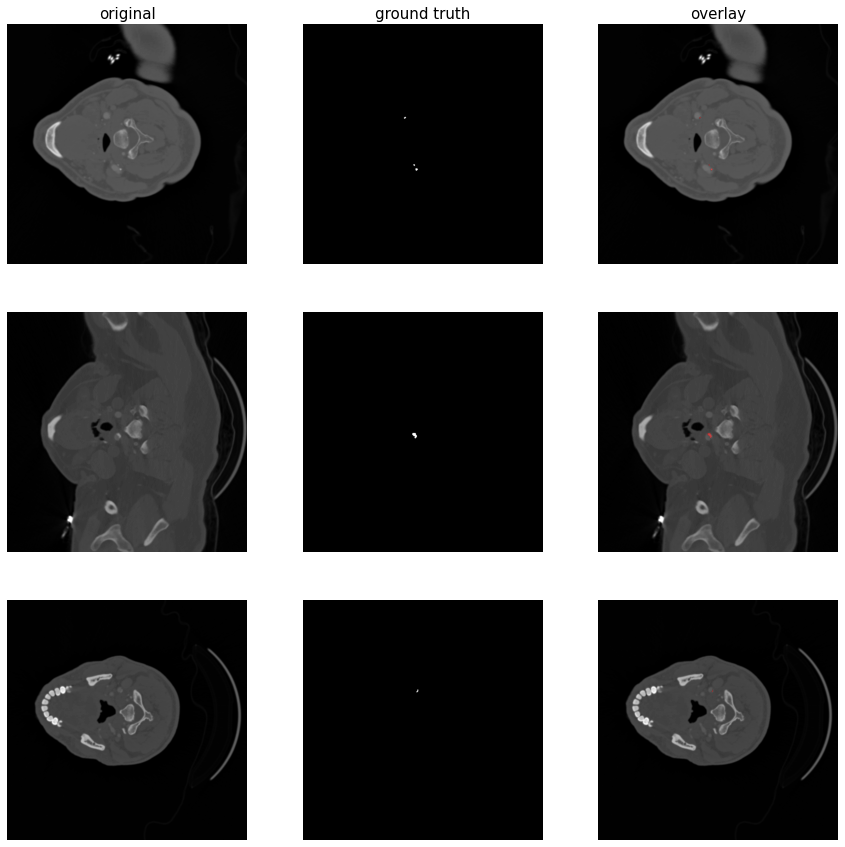

In [10]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=images, mask_imgs=labels, nm_img_to_plot=3, figsize=5)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_val, y_train, y_val = C.Util.split_1(images, labels, val_size=0.2)

In [13]:
from keras_unet_collection import models, losses
import torch

model = models.swin_unet_2d((512, 512, 1), filter_num_begin=64,
                               n_labels=1, depth=4, stack_num_down=4, stack_num_up=4,
                               patch_size=(4, 4), num_heads=[4, 8, 16, 16],
                               window_size=[4, 2, 2, 2], num_mlp=512, 
                               output_activation='Sigmoid', shift_window=True, name='swin_unet')

#Softmax

2023-05-01 03:02:35.544945: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-05-01 03:02:35.924946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0f:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-05-01 03:02:35.927585: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:90:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-05-01 03:02:35.927603: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-05-01 03:02:35.927638: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-05-01 

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [14]:
from tensorflow.keras import optimizers
from keras_unet.metrics import iou, iou_thresholded, dice_coef
from keras_unet_collection import losses

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate = 0.001),
              metrics=[iou, iou_thresholded])

In [16]:
history = model.fit(X_train,
                    y_train,
                    batch_size=16,
                    epochs=100,
                    validation_data=(X_val, y_val))
                    #callbacks = [earlystopping])

2023-05-01 03:02:46.458118: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-05-01 03:02:46.481164: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/100


2023-05-01 03:03:37.143631: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-05-01 03:03:39.436824: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-05-01 03:03:39.437142: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-01 03:03:39.587926: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-05-01 03:03:39.934492: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500
2023-05-01 03:03:41.501948: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-05-01 03:03:41.501970: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-05-01 03:03:41.50246

39/39 [==============================] - 95s 1s/step - loss: 0.1081 - iou: 8.7498e-04 - iou_thresholded: 0.0012 - val_loss: 0.0025 - val_iou: 0.0019 - val_iou_thresholded: 0.0026
Epoch 2/100
39/39 [==============================] - 28s 730ms/step - loss: 0.0035 - iou: 0.0012 - iou_thresholded: 0.0014 - val_loss: 0.0028 - val_iou: 0.0017 - val_iou_thresholded: 0.0026
Epoch 3/100
39/39 [==============================] - 29s 741ms/step - loss: 0.0022 - iou: 0.0014 - iou_thresholded: 0.0013 - val_loss: 0.0015 - val_iou: 0.0021 - val_iou_thresholded: 0.0026
Epoch 4/100
39/39 [==============================] - 29s 740ms/step - loss: 0.0016 - iou: 0.0019 - iou_thresholded: 0.0013 - val_loss: 0.0014 - val_iou: 0.0030 - val_iou_thresholded: 0.0026
Epoch 5/100
39/39 [==============================] - 29s 736ms/step - loss: 0.0014 - iou: 0.0026 - iou_thresholded: 0.0014 - val_loss: 0.0014 - val_iou: 0.0027 - val_iou_thresholded: 0.0026
Epoch 6/100
39/39 [==============================] - 29s 734m

Epoch 43/100
39/39 [==============================] - 29s 743ms/step - loss: 2.0845e-04 - iou: 0.4881 - iou_thresholded: 0.6086 - val_loss: 3.7417e-04 - val_iou: 0.3406 - val_iou_thresholded: 0.4192
Epoch 44/100
39/39 [==============================] - 29s 735ms/step - loss: 2.1108e-04 - iou: 0.4867 - iou_thresholded: 0.6092 - val_loss: 3.7723e-04 - val_iou: 0.3517 - val_iou_thresholded: 0.4156
Epoch 45/100
39/39 [==============================] - 29s 739ms/step - loss: 2.0288e-04 - iou: 0.4961 - iou_thresholded: 0.6185 - val_loss: 3.7489e-04 - val_iou: 0.3530 - val_iou_thresholded: 0.4248
Epoch 46/100
39/39 [==============================] - 29s 741ms/step - loss: 1.9452e-04 - iou: 0.5116 - iou_thresholded: 0.6384 - val_loss: 3.9794e-04 - val_iou: 0.3619 - val_iou_thresholded: 0.4161
Epoch 47/100
39/39 [==============================] - 29s 737ms/step - loss: 1.7860e-04 - iou: 0.5388 - iou_thresholded: 0.6656 - val_loss: 3.7245e-04 - val_iou: 0.3693 - val_iou_thresholded: 0.4379
Epoch

39/39 [==============================] - 29s 737ms/step - loss: 5.5543e-05 - iou: 0.8101 - iou_thresholded: 0.9053 - val_loss: 4.6547e-04 - val_iou: 0.4605 - val_iou_thresholded: 0.4794
Epoch 85/100
39/39 [==============================] - 29s 739ms/step - loss: 5.5688e-05 - iou: 0.8123 - iou_thresholded: 0.9042 - val_loss: 4.8986e-04 - val_iou: 0.4529 - val_iou_thresholded: 0.4722
Epoch 86/100
39/39 [==============================] - 29s 741ms/step - loss: 5.7735e-05 - iou: 0.8100 - iou_thresholded: 0.8984 - val_loss: 4.7376e-04 - val_iou: 0.4606 - val_iou_thresholded: 0.4804
Epoch 87/100
39/39 [==============================] - 29s 741ms/step - loss: 6.0045e-05 - iou: 0.8071 - iou_thresholded: 0.8925 - val_loss: 4.8179e-04 - val_iou: 0.4651 - val_iou_thresholded: 0.4881
Epoch 88/100
39/39 [==============================] - 29s 741ms/step - loss: 5.9310e-05 - iou: 0.8083 - iou_thresholded: 0.8918 - val_loss: 4.6922e-04 - val_iou: 0.4697 - val_iou_thresholded: 0.4922
Epoch 89/100
39/39

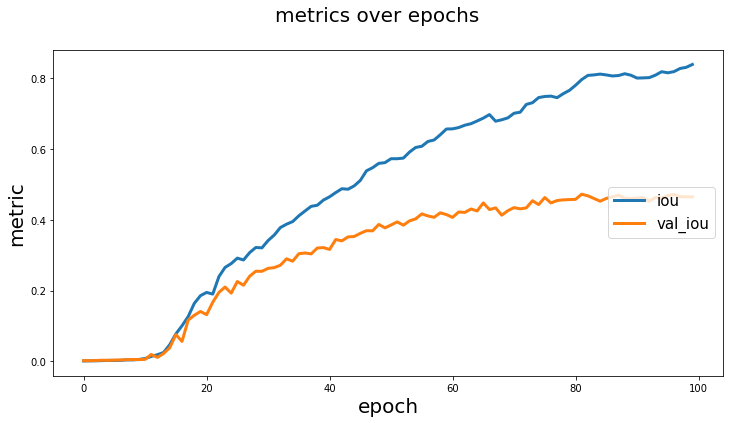

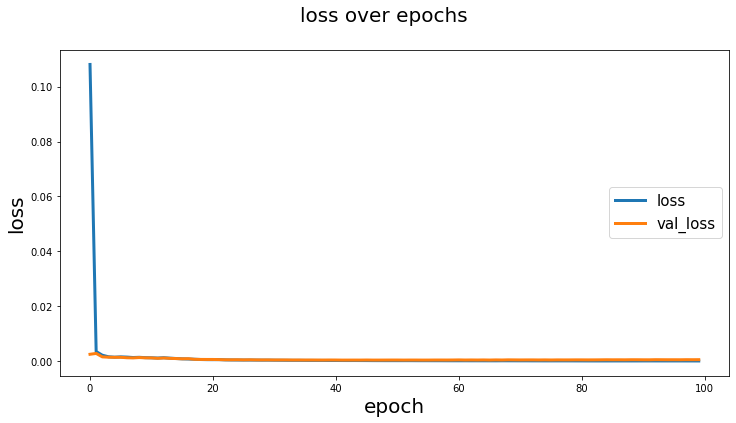

In [17]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [18]:
y_pred = model.predict(X_val)

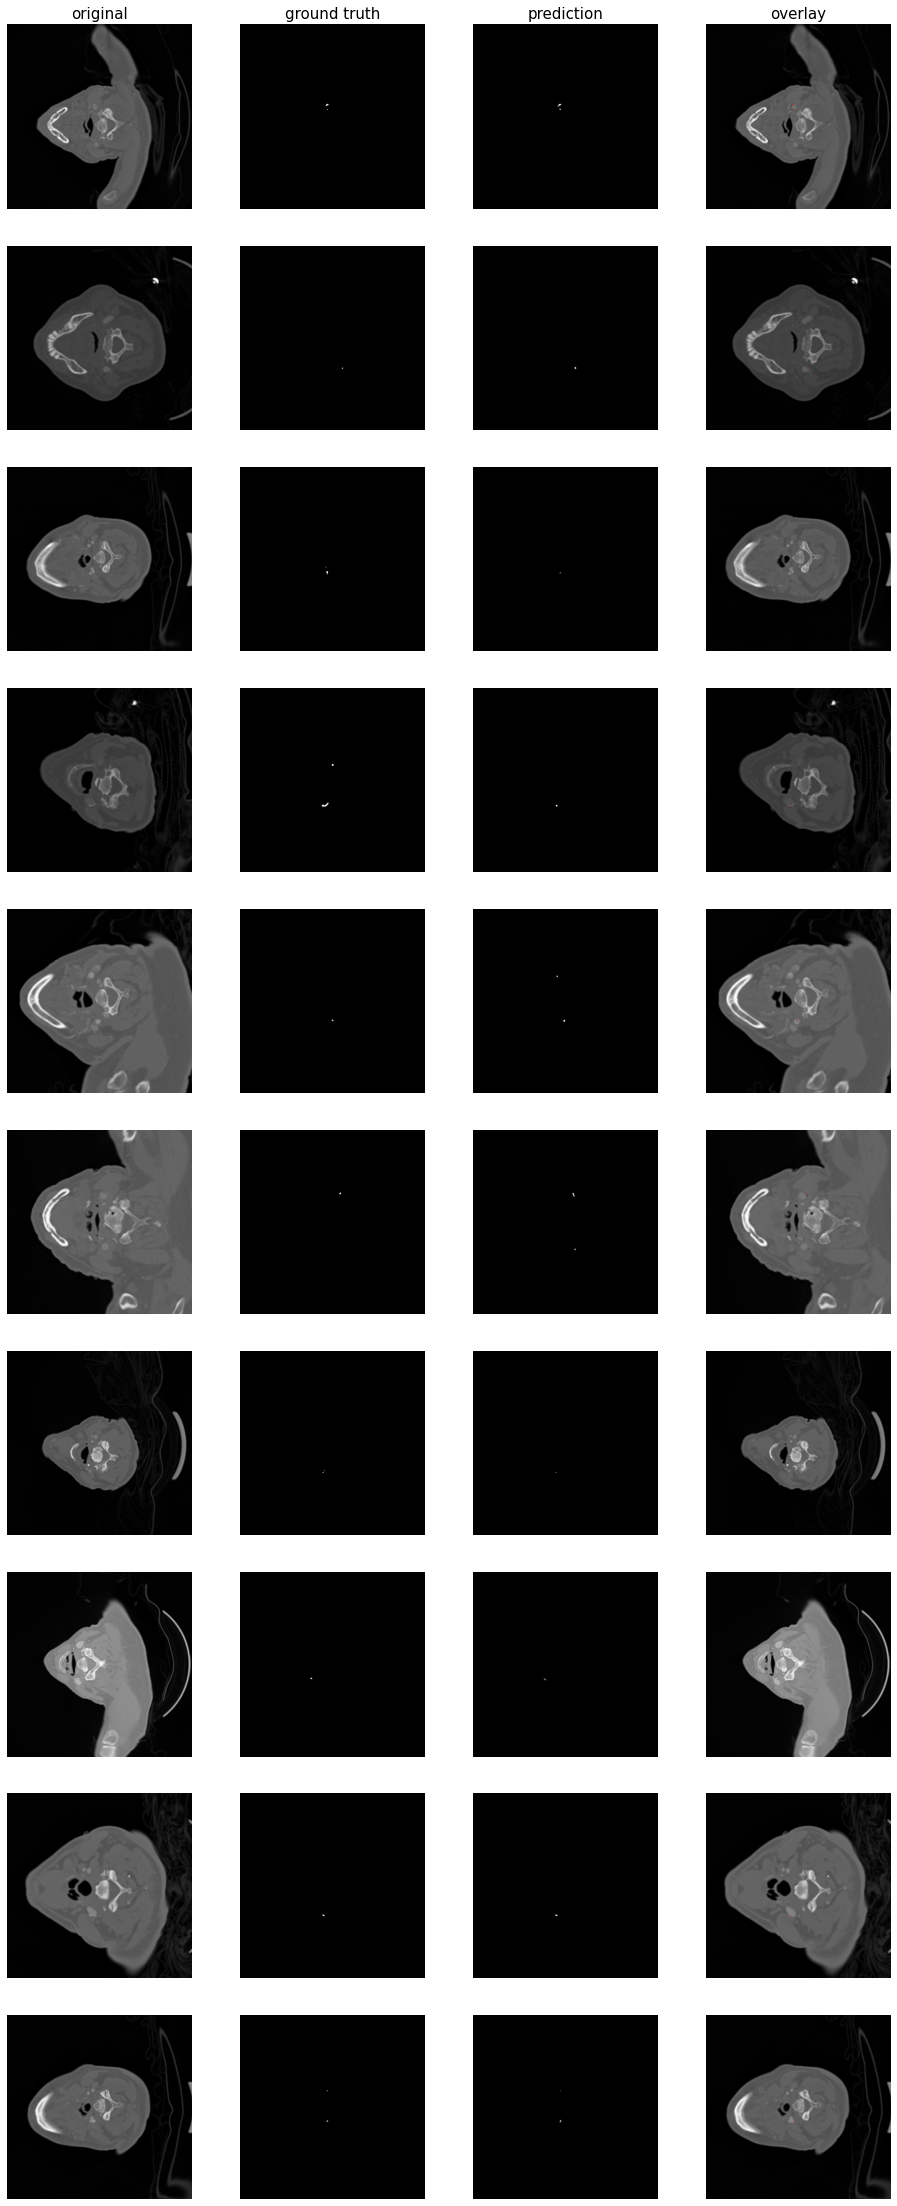

In [19]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [20]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

5/5 [==============================] - 2s 410ms/step - loss: 5.2312e-04 - iou: 0.4617 - iou_thresholded: 0.4755
